# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [175]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [176]:
websites = pd.read_csv(r"C:\Users\HP\Documents\IronHack\Bootcamp\IronHackLessons\Week7\LAB Supervised Learning\data\website.csv")

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [177]:
pd.set_option("max_columns",100)
display(websites.head())

print(websites.dtypes)
print(websites.shape)

display(websites.describe())

print(websites.isnull().sum())

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object
(1781, 21)


,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64


In [178]:
### What the dataset looks like?
# Shape(1781,21)

### What are the data types?
# websites.dtypes/info

# columns WHOIS_REGDATE & WHOIS_UPDATED_DATE should have a Datetime type
# a lot of "None" values

### The columns with the features that we'll predict and the code standing for Benign & Malicious:
#   - rest of features/characteristics are ALL others, maybe with exception of "Type"(predictor)
#   - column "Type" contains the feature we'll predict
#   - Bening=0, Malicious=1

### need to transform any columns from categorical to ordinal values? what are these columns?
#   - maybe "Charset", "Server", "WHOIS_COUNTRY","WHOIS_STATEPRO"
#   - because it would be easier to understand/study the data. Also, makes sense to organize by Country & State

#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

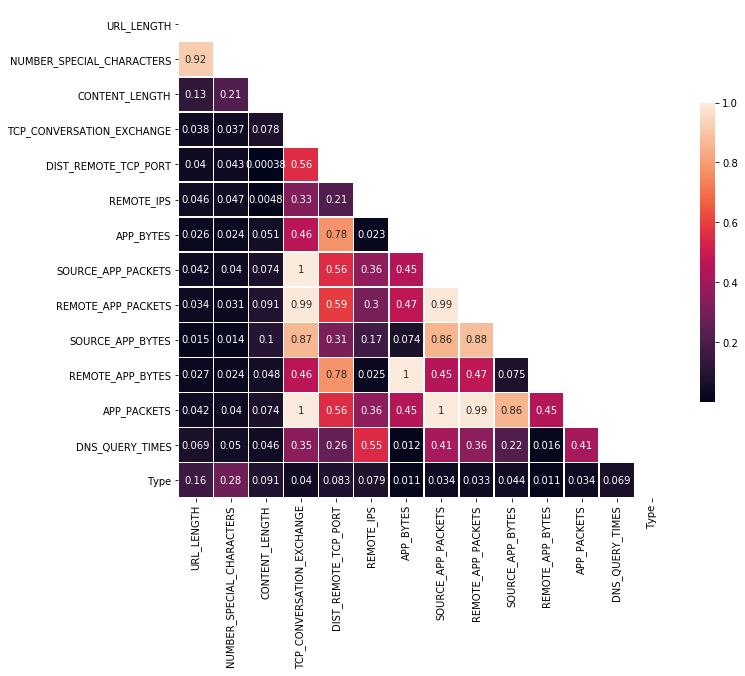

In [179]:
corr = np.absolute(websites.corr())

# mask for triangle representation
mask = np.triu(np.zeros_like(corr, dtype=np.bool))
mask[np.triu_indices_from(mask)] = True

# setting up matplotlib figure
f, ax = plt.subplots(figsize=(11,11))
# Drawing heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=corr, linewidths=0.5, cbar_kws={"shrink":0.5})

plt.show()

In [180]:
# Correlation >= 0.90:
#   - NUMBER_SPECIAL_CHARACTERS vs URL_LENGTH --> 0.92
#   - SOURCE_APP_PACKETS vs TCP_CONVERSATION_EXCHANGE --> 1
#   - REMOTE_APP_PACKETS vs TCP_CONVERSATION_EXCHANGE --> 0.99
#   - REMOTE_APP_PACKETS vs SOURCE_APP_PACKETS --> 0.99
#   - REMOTE_APP_BYTES vs APP_BYTES --> 1
#   - APP_PACKETS vs TCP_CONVERSATION_EXCHANGE --> 1
#   - APP_PACKETS vs SOURCE_APP_PACKETS --> 1
#   - APP_PACKETS vs REMOTE_APP_PACKETS --> 0.99

# a few columns look pretty similar (we should remove does that are essencially repeated to avoid double counting our model)

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [181]:
websites.drop(columns=["NUMBER_SPECIAL_CHARACTERS","SOURCE_APP_PACKETS", "REMOTE_APP_PACKETS","REMOTE_APP_BYTES","TCP_CONVERSATION_EXCHANGE"], inplace=True)

In [182]:
### Reasons to DROP: 
# SOURCE_APP_PACKETS & REMOTE_APP_PACKETS seems to have the same values(or at least pretty similar) to APP_PACKETS
# REMOVE_APP_BYTES follows same logic of the PACKETS
# NUMBER_SPECIAL_CHARACTERS (seems useless & similar to URL_LENGTH) & TCP_CONVERSATION_EXCHANGE (a lot of high Corr with other columns)

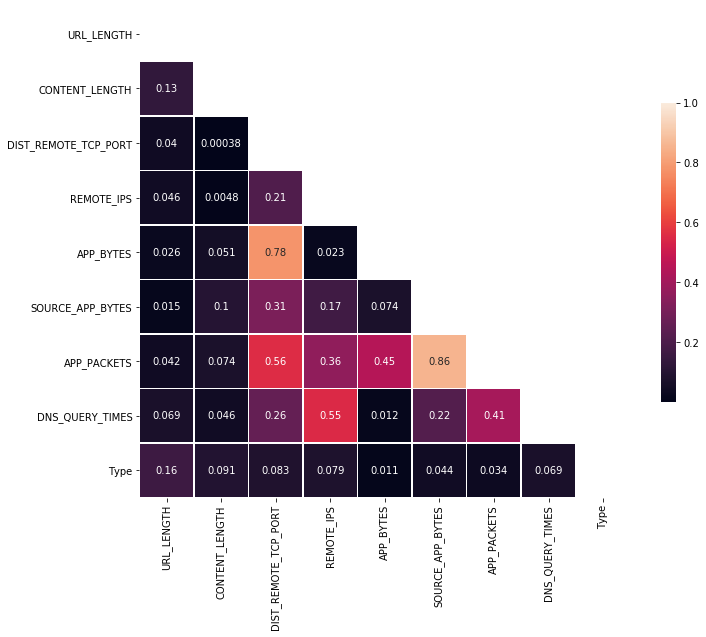

In [183]:
# Print heatmap again

corr = np.absolute(websites.corr())

# mask for triangle representation
mask = np.triu(np.zeros_like(corr, dtype=np.bool))
mask[np.triu_indices_from(mask)] = True

# setting up matplotlib figure
f, ax = plt.subplots(figsize=(11,11))
# Drawing heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=corr, linewidths=0.5, cbar_kws={"shrink":0.5})

plt.show()

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [184]:
websites.isna().sum() 
# OR websites.isnull().sum()

URL                       0
URL_LENGTH                0
CHARSET                   0
SERVER                    1
CONTENT_LENGTH          812
WHOIS_COUNTRY             0
WHOIS_STATEPRO            0
WHOIS_REGDATE             0
WHOIS_UPDATED_DATE        0
DIST_REMOTE_TCP_PORT      0
REMOTE_IPS                0
APP_BYTES                 0
SOURCE_APP_BYTES          0
APP_PACKETS               0
DNS_QUERY_TIMES           1
Type                      0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [185]:
# to many missing values from this column to worth keep it
websites.drop(columns=["CONTENT_LENGTH"],axis=1,inplace=True)

# dropping all rows with missing values (no point keep this rows)
websites.dropna(axis=0,inplace=True)

In [186]:
# explain reasons above

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [187]:
# Examine missing values in each column
websites.isnull().sum()

URL                     0
URL_LENGTH              0
CHARSET                 0
SERVER                  0
WHOIS_COUNTRY           0
WHOIS_STATEPRO          0
WHOIS_REGDATE           0
WHOIS_UPDATED_DATE      0
DIST_REMOTE_TCP_PORT    0
REMOTE_IPS              0
APP_BYTES               0
SOURCE_APP_BYTES        0
APP_PACKETS             0
DNS_QUERY_TIMES         0
Type                    0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [188]:
websites["WHOIS_COUNTRY"].unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [189]:
websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].str.upper()

# fix countries values
websites["WHOIS_COUNTRY"][websites["WHOIS_COUNTRY"]=="CYPRUS"]="CY" 
websites["WHOIS_COUNTRY"][websites["WHOIS_COUNTRY"]=="UNITED KINGDOM"]="UK" 
websites["WHOIS_COUNTRY"][websites["WHOIS_COUNTRY"]=="GB"]="UK"
websites["WHOIS_COUNTRY"][websites["WHOIS_COUNTRY"]=="[U'GB'; U'UK']"]="UK" 


websites["WHOIS_COUNTRY"].unique()

C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:7: Se

array(['NONE', 'US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU',
       'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT', 'CZ',
       'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK', 'UA',
       'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

,index,WHOIS_COUNTRY
0,US,1105
1,NONE,306
2,CA,83
3,ES,63
4,UK,35
5,AU,35
6,PA,21
7,JP,11
8,CN,10
9,IN,10


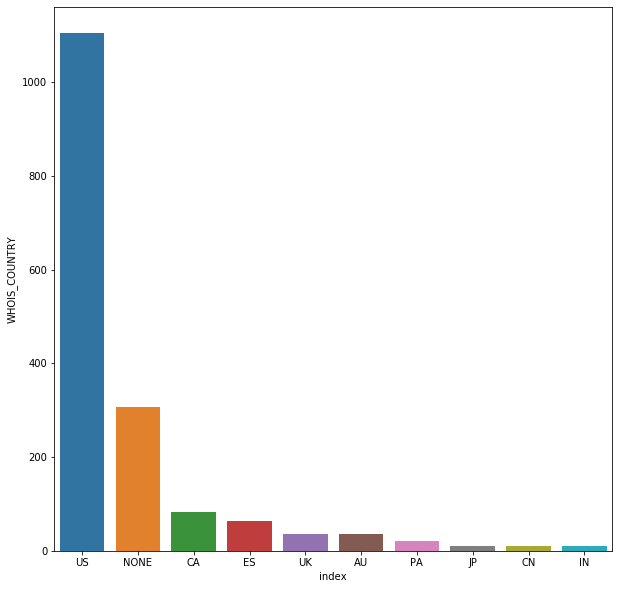

In [190]:
ordered_countries = websites['WHOIS_COUNTRY'].value_counts().reset_index()
display(ordered_countries.head(10))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(x="index", y="WHOIS_COUNTRY", data=ordered_countries.head(10))
plt.show()

#from matplotlib.pyplot import figure
#figure(num=None, figsize=(8,8))
#plt.barh(ordered_countries, websites["WHOIS_COUNTRY"].value_counts(), align="center", alpha=0.5)

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [191]:
# place the values that arent in "ordered_countries" in "other"
# to_replace(all but top 10 contries, put them in "other")

websites["WHOIS_COUNTRY"].replace(to_replace=ordered_countries["index"][:10], value="other", inplace=True)

websites["WHOIS_COUNTRY"].value_counts()

US       1105
NONE      305
CA         83
ES         63
AU         35
UK         35
PA         21
JP         11
IN         10
CN         10
CZ          9
FR          9
CH          6
RU          6
NL          6
KR          5
SE          4
PH          4
BS          4
AT          4
KY          3
HK          3
TR          3
SC          3
BE          3
DE          3
UY          2
KG          2
UA          2
SI          2
NO          2
IL          2
BR          2
CY          2
IE          1
BY          1
LU          1
IT          1
other       1
PK          1
LV          1
TH          1
UG          1
AE          1
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [192]:
websites.drop(columns=["WHOIS_STATEPRO", "WHOIS_REGDATE", "WHOIS_UPDATED_DATE"],inplace=True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [193]:
websites.dtypes

URL                      object
URL_LENGTH                int64
CHARSET                  object
SERVER                   object
WHOIS_COUNTRY            object
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
APP_BYTES                 int64
SOURCE_APP_BYTES          int64
APP_PACKETS               int64
DNS_QUERY_TIMES         float64
Type                      int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [194]:
websites.drop(columns=["URL"], inplace=True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [195]:
websites["CHARSET"].value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
ISO-8859          1
windows-1252      1
windows-1251      1
Name: CHARSET, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [196]:
websites["SERVER"].unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', 'None',
       'Apache/2', 'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips'

![Think Hard](../images/think-hard.jpg)

In [197]:
# Your comment here


Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [198]:
websites["SERVER"][websites["SERVER"].str.contains("Microsoft")]="Microsoft"
websites["SERVER"][websites["SERVER"].str.contains("Apache")]="Apache"
websites["SERVER"][websites["SERVER"].str.contains("nginx")]="nginx"
websites["SERVER"][~websites["SERVER"].isin(["Microsoft","Apache","nginx"])]="other"

C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\HP\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [199]:
# Count `SERVER` value counts here
websites["SERVER"].value_counts()

Apache       642
other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [200]:
website_dummy = pd.get_dummies(websites, columns=["CHARSET","SERVER","WHOIS_COUNTRY"]) 

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [201]:
print(website_dummy.dtypes)
display(website_dummy)

URL_LENGTH              int64
DIST_REMOTE_TCP_PORT    int64
REMOTE_IPS              int64
APP_BYTES               int64
SOURCE_APP_BYTES        int64
                        ...  
WHOIS_COUNTRY_UG        uint8
WHOIS_COUNTRY_UK        uint8
WHOIS_COUNTRY_US        uint8
WHOIS_COUNTRY_UY        uint8
WHOIS_COUNTRY_other     uint8
Length: 65, dtype: object


,URL_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,CHARSET_ISO-8859,CHARSET_ISO-8859-1,CHARSET_None,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Apache,SERVER_Microsoft,SERVER_nginx,SERVER_other,WHOIS_COUNTRY_AE,WHOIS_COUNTRY_AT,WHOIS_COUNTRY_AU,WHOIS_COUNTRY_BE,WHOIS_COUNTRY_BR,WHOIS_COUNTRY_BS,WHOIS_COUNTRY_BY,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CH,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_CY,WHOIS_COUNTRY_CZ,WHOIS_COUNTRY_DE,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_FR,WHOIS_COUNTRY_HK,WHOIS_COUNTRY_IE,WHOIS_COUNTRY_IL,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_IT,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_KG,WHOIS_COUNTRY_KR,WHOIS_COUNTRY_KY,WHOIS_COUNTRY_LU,WHOIS_COUNTRY_LV,WHOIS_COUNTRY_NL,WHOIS_COUNTRY_NO,WHOIS_COUNTRY_NONE,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_PH,WHOIS_COUNTRY_PK,WHOIS_COUNTRY_RU,WHOIS_COUNTRY_SC,WHOIS_COUNTRY_SE,WHOIS_COUNTRY_SI,WHOIS_COUNTRY_TH,WHOIS_COUNTRY_TR,WHOIS_COUNTRY_UA,WHOIS_COUNTRY_UG,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US,WHOIS_COUNTRY_UY,WHOIS_COUNTRY_other
0,16,0,2,700,1153,9,2.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,7,4,1230,1265,17,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,16,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17,22,3,3812,18784,39,8.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,17,2,5,4278,129889,61,4.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,0,0,0,186,0,0.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1777,198,0,0,0,124,0,0.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1778,201,2,6,6631,132181,87,4.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1779,234,0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [202]:
from sklearn.model_selection import train_test_split

y = website_dummy["Type"]
x = website_dummy.loc[:, website_dummy.columns != "Type"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)   # random_state = 0 or 1

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [203]:
from sklearn.linear_model import LogisticRegression

# initiate model
model = LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [204]:
# training model on the training datasets -> where the algorithm will learn
model = model.fit(x_train, y_train)

C:\Users\HP\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [205]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


y_pred = model.predict(x_test)

print("Classification report:", classification_report(y_pred,y_test))   # accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(model.predict(x_test),y_test))
print("Test data accuracy:", model.score(x_test,y_test))  # the same as accuracy score
print("Train data accuracy:", model.score(x_train, y_train))

Classification report:               precision    recall  f1-score   support

           0       0.96      0.91      0.93       328
           1       0.33      0.54      0.41        28

    accuracy                           0.88       356
   macro avg       0.65      0.72      0.67       356
weighted avg       0.91      0.88      0.89       356

Accuracy Score: 0.8792134831460674
Confusion Matrix: [[298  30]
 [ 13  15]]
Test data accuracy: 0.8792134831460674
Train data accuracy: 0.893183415319747


What are your thoughts on the performance of the model? Write your conclusions below.

In [206]:
# Confusion Matrix: 30 False positives & 13 false negatives its not that good, we should try improving

# 88% its not bad but not great! It means that the model fails to flag a few malicious sites

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [207]:
from sklearn.neighbors import KNeighborsClassifier

# iniciar modelo 
model = KNeighborsClassifier(n_neighbors=3)

# treinar modelo
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)


# avaliar se modelo se está a portar bem com a Test Data
# Score (chamar dps de treinar modelo). Compara resultados das Test prediction com os valores reais (accuracy)
print("Test accuracy:",model.score(x_test,y_test))

# ver accuracy do Train
print("Train accuracy:",model.score(x_train,y_train))  

Test accuracy: 0.9129213483146067
Train accuracy: 0.9627547434996486


To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [208]:
display(confusion_matrix(y_pred,y_test))
display(accuracy_score(y_test, y_pred))

array([[295,  15],
       [ 16,  30]], dtype=int64)

0.9129213483146067

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [209]:
# iniciar modelo
model = KNeighborsClassifier(n_neighbors=5)

# treinar modelo
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)


print("Test accuracy:",model.score(x_test,y_test))
print("Train accuracy:",model.score(x_train,y_train))


display(confusion_matrix(y_pred,y_test))
display(accuracy_score(y_test, y_pred))

Test accuracy: 0.9157303370786517
Train accuracy: 0.9508081517919887


array([[298,  17],
       [ 13,  28]], dtype=int64)

0.9157303370786517

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [210]:
# a slightly improvement (about 3%) and confusion matrix as just a few less False positive/negatives



# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [38]:
# Your code here